# Capstone Project 2
# How Soon Will a Complaint be Resolved?
## A Case Study on New York City 311 Call
## Final Report

Data Source: NYC Open Data - 311 Service Requests from 2010 to Present  
URL: https://nycopendata.socrata.com/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9  
Analyst: Eugene Wen

### Background
New York City 311 call data is part of the NYC Opendata project that provides many interesting information about the 311 calls filing complaints to the NYPD. An important aspect is how fast an array of city agencies close the complaints.

This analysis attempted to predict, at the time of filing the complaint, how soon in average the case would be resolved (closed). Also, it would be interesting to find out which variable plays important role in the response time.

The full dataset in CSV format can be downloaded from NYC Opendata website.

### Subsample datasets for model development
First installed subsample package through pip, then changed directory to NYC311 data folder and run command as follows to randomly draw 500,000 rows:

`subsample -n 500000 311_Service_Requests_from_2010_to_Present.csv -r > nyc311_sample.csv`  

Note that this dataset is used for development. In the final report all 10GB data will be used for analysis.

In [1]:
# Load packages
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession

# Start a spark session
spark = SparkSession.builder.appName('nyc311').getOrCreate()

In [2]:
# Load sample dataset
df = spark.read.csv('../NYC311/nyc311_sample.csv', inferSchema=False, header=True)

### Data Wrangling

#### Derive the Target Variable: Response Time

The dataset includes two timestamp columns: Created Date, which indicates that when the case was created in the system, and Closed Data, which recorded when the case was resolved and closed. The difference between the two timestamps is the actual response time, i.e. how long it took to complete the case from filing time, in seconds.

For convenience, the response time in seconds was converted into days by applying the ceiling of the day fraction. If the case was resolved immediately, the response time in days would be 1 day.

In [3]:
# Calculate the response time as the difference between created date and closed date, in minutes.
from pyspark.sql.functions import unix_timestamp, floor

fmt = "MM/dd/yyyy hh:mm:ss a"
# fmt2 = "MM/dd/yyyy HH:mm:ss" ## 12-Hr based time. Can't handle AM/PM.
starttime = unix_timestamp(df['Created Date'], format=fmt)
endtime = unix_timestamp(df['Closed Date'], format=fmt)

df = df.withColumn("Resp_time", floor((endtime - starttime)/86400) + 1)
df['Unique Key', 'Resp_time'].show(10)

+----------+---------+
|Unique Key|Resp_time|
+----------+---------+
|  32199603|       22|
|  20074547|        2|
|  28951515|        1|
|  17575598|        5|
|  28270434|        3|
|  34115581|       13|
|  28261221|        1|
|  22829180|        2|
|  29709630|        1|
|  20809019|        8|
+----------+---------+
only showing top 10 rows



#### Choice of  Variables

It is noticed that a number of variables have very little information, such as Taxi Company Borough and Road Ramp. These variables were dropped.

Also, Borough has general geographical information. Therefore, there was no need to keep the coordinate information unless for spatial analysis (which we won't conduct here anyway).

The variables Park Facility Name and starting with School, although seem to have quite rich information, have a major portion of "Unspecified" category which does not have useful information. These variables should also be dropped.

In [4]:
# Example of category distribution for Park Fercility Name
from pyspark.sql.functions import desc
df.groupby('Park Facility Name').count().sort(desc("count")).show(10)

+--------------------+-----+
|  Park Facility Name|count|
+--------------------+-----+
|         Unspecified|49653|
|        Central Park|   18|
|       Prospect Park|    7|
|   Hudson River Park|    7|
|      Riverside Park|    5|
|        Astoria Park|    4|
|Flushing Meadows ...|    4|
|      City Hall Park|    3|
|       John Jay Park|    3|
|     Alley Pond Park|    3|
+--------------------+-----+
only showing top 10 rows



In [5]:
# Choose the variables
df_input = df.select(["Unique Key", "Created Date", "Closed Date", "Agency", "Complaint Type", "Status", "Borough", \
                      "Park Borough", "Resp_time"])

#### Eliminate incorrectly parsed rows
A few rows were identified to be incorrectly parsed while reading in the CSV file. Given the very low number of problematic rows we decided to eliminate them from analysis.

See example below: the variable Park Borough in the original dataset was OK but the dataframe in memory has three rows that having mis-alignment issue.

In [6]:
df.groupby('Park Borough').count().sort(desc("count")).show(10)

+-------------+-----+
| Park Borough|count|
+-------------+-----+
|     BROOKLYN|14279|
|       QUEENS|10990|
|    MANHATTAN| 9794|
|        BRONX| 8480|
|  Unspecified| 4031|
|STATEN ISLAND| 2423|
|       225841|    1|
|       195829|    1|
|       185215|    1|
+-------------+-----+



In [7]:
df_input.filter("`Park Borough` == '225841'").show()

+----------+--------------------+--------------------+------+--------------+------+--------------------+------------+---------+
|Unique Key|        Created Date|         Closed Date|Agency|Complaint Type|Status|             Borough|Park Borough|Resp_time|
+----------+--------------------+--------------------+------+--------------+------+--------------------+------------+---------+
|  18741880|09/22/2010 03:05:...|11/04/2010 10:30:...|   DEP|         Noise|Closed|11/04/2010 10:30:...|      225841|       43|
+----------+--------------------+--------------------+------+--------------+------+--------------------+------------+---------+



In [8]:
# Drop the three rows with incorrect parsing
borough = {"BROOKLYN", "QUEENS", "MANHATTAN", "BRONX", "Unspecified", "STATEN ISLAND"}
df_input_clean = df_input.filter(df_input["Park Borough"].isin(borough) == True)

### Exploratory Data Analysis

In [9]:
# Plot response time distribution
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
df_input_pd = df_input.toPandas()

We would like to check the distribution of the derived response time variable. It looks like there are some negative values!

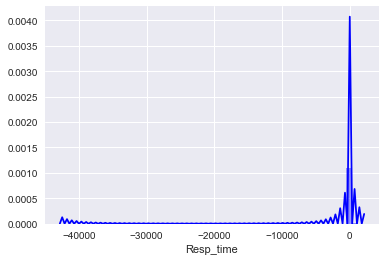

In [10]:
sns.set()
sns.distplot(df_input_pd.Resp_time.dropna(), kde=True, color='b')

A further drill down of these negative values and missing values showed that for some reason, about 5% data have Closed Data earlier than the Created Data, or missing the Closed Data (remains open). By looking up the website and related documentations, there apparently was neither clear explanation nor solution. We therefore decided to drop these rows.

In [11]:
df_input = df_input.filter("`Resp_time` > 0")

Plot the distribution of the response time again showed that the distribution is very skewed. We then tried to plot in log scale and the plot improved.

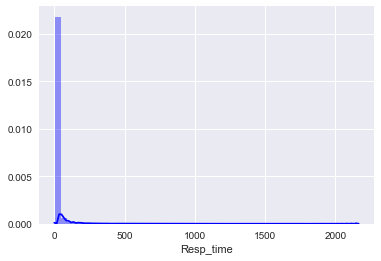

In [12]:
# Plot the distribution of response time again
sns.set()
sns.distplot(df_input.toPandas().Resp_time, kde=True, color='b')

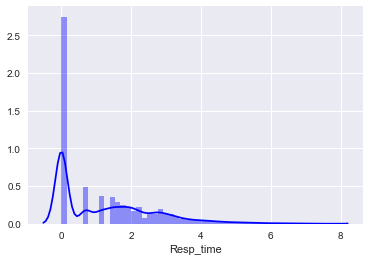

In [13]:
# Plot the distribution of response time again, with log transformation
sns.set()
sns.distplot(np.log(df_input.toPandas().Resp_time), kde=True, color='b')

The log scale response time variable was created in the dataframe and will be used as the target variable.

In [14]:
# Create log scale response time instead for modeling
from pyspark.sql.functions import log
df_input = df_input.withColumn("log_Resp_time", log(df_input.Resp_time))

### Machine Learning Models

In [15]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

indexer1 = StringIndexer(inputCol="Agency", outputCol="AgencyVec")
indexer2 = StringIndexer(inputCol="Complaint Type", outputCol="CompTypeVec")
indexer3 = StringIndexer(inputCol="Borough", outputCol="BoroughVec")
indexer4 = StringIndexer(inputCol="Park Borough", outputCol="PBoroughVec")

assembler = VectorAssembler(inputCols=["AgencyVec", "CompTypeVec", "BoroughVec", "PBoroughVec"], outputCol='features')

pipeline = Pipeline(stages = [indexer1, indexer2, indexer3, indexer4, assembler])

df_input_dense = pipeline.fit(df_input).transform(df_input)

df_input_final = df_input_dense.select(['features', 'log_Resp_time'])

In [16]:
df_input_final.show(10)

+-------------------+------------------+
|           features|     log_Resp_time|
+-------------------+------------------+
| [8.0,28.0,1.0,1.0]| 3.091042453358316|
|  [2.0,3.0,0.0,0.0]|0.6931471805599453|
|[12.0,39.0,4.0,4.0]|               0.0|
| [4.0,17.0,5.0,5.0]|1.6094379124341003|
| [0.0,72.0,5.0,5.0]|1.0986122886681098|
|     (4,[1],[18.0])|2.5649493574615367|
| [1.0,16.0,1.0,1.0]|               0.0|
| [6.0,52.0,0.0,0.0]|0.6931471805599453|
|[9.0,105.0,2.0,2.0]|               0.0|
| [0.0,18.0,3.0,3.0]|2.0794415416798357|
+-------------------+------------------+
only showing top 10 rows



In [17]:
# Split dataset into training and testing sets
train_data, test_data = df_input_final.randomSplit([0.7, 0.3])

In [18]:
# First run
from pyspark.ml.regression import LinearRegression

# training set requires two columns: label and features.

lr = LinearRegression(featuresCol = 'features', \
                      labelCol = 'log_Resp_time', \
                      predictionCol = 'prediction')
lrModel = lr.fit(train_data)
lrModel.coefficients
lrModel.intercept
training_summary = lrModel.summary
training_summary.r2
training_summary.rootMeanSquaredError

1.3875192368006197

In [19]:
test_results = lrModel.evaluate(test_data)
test_results.rootMeanSquaredError

1.3910773227743898

#### Other ML Models

In [20]:
# Other models using default setup
from pyspark.ml.regression import RandomForestRegressor, \
                                  GBTRegressor, \
                                  GeneralizedLinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

In [22]:
from pyspark.sql.functions import mean
# Generalized Linear Regression
glm = GeneralizedLinearRegression(featuresCol='features',\
                                  labelCol='log_Resp_time', \
                                  predictionCol='prediction',\
                                  family="poisson", link="log")
glmModel = glm.fit(train_data)

# Evaluate on test set

test_results_glm = glmModel.transform(test_data)
test_results_glm = test_results_glm.withColumn("sqdiff", (test_results_glm["prediction"] - test_results_glm["log_Resp_time"]) * \
                                                         (test_results_glm["prediction"] - test_results_glm["log_Resp_time"]))

RMSE_glm = test_results_glm.select(mean(test_results_glm["sqdiff"]))
RMSE_glm.show()

+------------------+
|       avg(sqdiff)|
+------------------+
|1.9535585255809984|
+------------------+



In [23]:
# Random Forest
rf = RandomForestRegressor(featuresCol='features',\
                           labelCol='log_Resp_time', \
                           predictionCol='prediction',\
                           numTrees=500, maxDepth=5, maxBins=500, seed=1000)
rfModel = rf.fit(train_data)

# Evaluate on test set

test_results_rf = rfModel.transform(test_data)
test_results_rf = test_results_rf.withColumn("sqdiff", (test_results_rf["prediction"] - test_results_rf["log_Resp_time"]) * \
                                                       (test_results_rf["prediction"] - test_results_rf["log_Resp_time"]))

from pyspark.sql.functions import mean
RMSE_rf = test_results_rf.select(mean(test_results_rf["sqdiff"]))
RMSE_rf.show()

+------------------+
|       avg(sqdiff)|
+------------------+
|0.8738678137422945|
+------------------+



In [24]:
# Gradient Boosting Tree
gbt = GBTRegressor(featuresCol='features',\
                   labelCol='log_Resp_time', \
                   predictionCol='prediction',\
                   maxIter=10, maxDepth=5, maxBins=500, seed=1000)
gbtModel = gbt.fit(train_data)

# Evaluate on test set

test_results_gbt = gbtModel.transform(test_data)
test_results_gbt = test_results_gbt.withColumn("sqdiff", (test_results_gbt["prediction"] - test_results_gbt["log_Resp_time"]) * \
                                                         (test_results_gbt["prediction"] - test_results_gbt["log_Resp_time"]))

RMSE_gbt = test_results_gbt.select(mean(test_results_gbt["sqdiff"]))
RMSE_gbt.show()

+------------------+
|       avg(sqdiff)|
+------------------+
|0.8780523057012175|
+------------------+



In [25]:
# Variable Importance
gbtModel.featureImportances

SparseVector(4, {0: 0.036, 1: 0.8167, 2: 0.1473})

In [26]:
spark.stop()